<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day3/unet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a U-net

The [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a very popular model architecture for segmentation in bioimage analysis.
Here, we will train a 2D U-net for nuclei segmentation, using data from the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

## The libraries

In [1]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

from pathlib import Path

## Data loading and preprocessing

In [2]:
data_dir = Path(r"/g/kreshuk/buglakova/data/cryofib")
images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
labels_dir = data_dir / "corrected_labels" / "train"

In [3]:
list(images_dir.glob("*.tiff"))[3]

PosixPath('/g/kreshuk/buglakova/data/cryofib/F107_bin2_619-639_frames/train/F107_bin2_619-639_04.tiff')

In [4]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

In [5]:
image = list(images_dir.glob("*.tiff"))[0]
mask = list(labels_dir.glob("*.tiff"))[0]

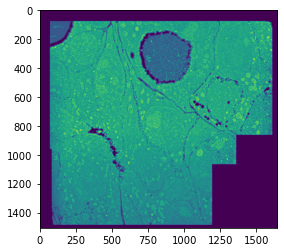

In [6]:
show_one_image(image)

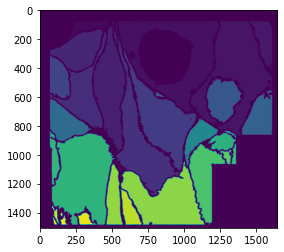

In [7]:
show_one_image(mask)

In [8]:
image = imageio.imread(list(images_dir.glob("*.tiff"))[5])
mask = imageio.imread(list(labels_dir.glob("*.tiff"))[5])

In [9]:
def convert_to_chan(mask):
    # 0 is out of sample
    # 1 is border
    # 2 is extracellular
    # >2 are cell instances
    mask_chan = np.stack([mask > 2, mask == 0, mask == 1, mask == 2], axis=-1).astype(int)
    return mask_chan


def split_with_overlap(image, tile_size=(256, 512), overlap=0.1):
    nonzero_ind = np.nonzero(image)
    tile_size = np.array(tile_size)
    overlap_size = np.floor(overlap * tile_size)
    trunc_size = (tile_size - overlap_size).astype(int)
    ind_min = np.min(nonzero_ind, axis=1)
    ind_max = np.max(nonzero_ind, axis=1)

    n_tiles = np.ceil((ind_max - ind_min) / trunc_size).astype(int)
    ind_min = np.multiply(np.indices(dimensions=n_tiles), trunc_size[:, None, None]) + ind_min[:, None, None]
    ind_min = ind_min.reshape((2, -1))
    ind_max = ind_min + tile_size[:, None]
    return n_tiles, ind_min, ind_max


def crop_tile(img, ind_min, ind_max):
    pad_w = ind_max - img.shape
    pad_w[pad_w < 0] = 0
    pad_w = np.stack((np.zeros_like(pad_w), pad_w)).T
    img_padded = np.pad(img, pad_width=pad_w)
    return img_padded[ind_min[0]:ind_max[0], ind_min[1]:ind_max[1], ...]


In [10]:
tile_layout, ind_min, ind_max = split_with_overlap(image, tile_size=(1024, 1024), overlap=0.1)

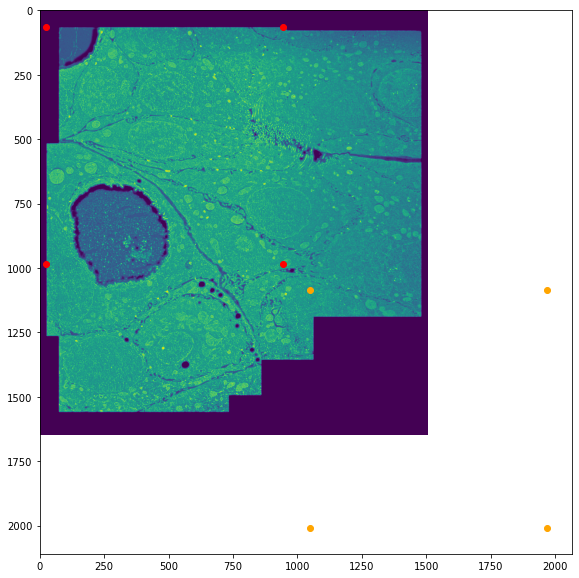

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image.T)
plt.scatter(ind_min[0, :], ind_min[1, :], c="r")
plt.scatter(ind_max[0, :], ind_max[1, :], c="orange")

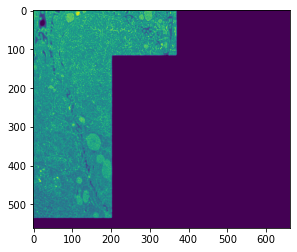

In [12]:
n = -1
plt.imshow(image[ind_min[:, n][0]:ind_max[:, n][0], ind_min[:, n][1]:ind_max[:, n][1], ...])

In [13]:
class EMDataset(Dataset):
    """ A PyTorch dataset to load volume EM images and manually segmented masks """
    def __init__(self, img_path, mask_path, tile_size=(512, 512), transform=None):
        self.img_path = Path(img_path)  # the directory with all the training samples
        self.mask_path = Path(mask_path)  # the directory with all the training samples
        self.img_list = sorted(list(self.img_path.glob("*.tiff"))) # list the samples
        self.mask_list = sorted(list(self.mask_path.glob("*.tiff")))

        self.tile_size = tile_size
        self.transform = transform    # transformations to apply to both inputs and targets
        #  transformations to apply just to inputs
        self.inp_transforms = [transforms.ToTensor()]
        # transformations to apply just to targets
        self.mask_transforms = transforms.ToTensor()

    # get the total number of samples
    def __len__(self):
        return len(self.img_list)


    # fetch the training sample given its index
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        mask_path = self.mask_list[idx]
        # we'll be using Pillow library for reading files
        # since many torchvision transforms operate on PIL images 
        image = imageio.imread(img_path)
        mask = imageio.imread(mask_path)
        
        tile_layout, ind_min, ind_max = split_with_overlap(image, tile_size=self.tile_size, overlap=0.3)
        n_tiles = ind_min.shape[1]
        # print(n_tiles, ind_min.shape, ind_max.shape)

        # Crop random tile
        rand_n = np.random.randint(low=0, high=n_tiles)
        # print(rand_n)

        img_tile = crop_tile(image, ind_min[:, rand_n], ind_max[:, rand_n])
        mask_tile = crop_tile(mask, ind_min[:, rand_n], ind_max[:, rand_n])

        # Convert mask into channels
        mask_tile = convert_to_chan(mask_tile)
        # print("Converted tile shape ", mask_tile.shape)

        # Apply transformations
        inp_transforms_idx = self.inp_transforms.copy()
        inp_transforms_idx.append(transforms.Normalize([np.mean(image)], [np.std(image)]))
        inp_transforms_idx = transforms.Compose(self.inp_transforms)
        img_tile = inp_transforms_idx(img_tile)
        mask_tile = self.mask_transforms(mask_tile)

        # print("tile shape", img_tile.shape)
        if self.transform is not None:
            img_tile, mask_tile = self.transform([img_tile, mask_tile])
        return img_tile, mask_tile


    def get_tiles(self, idx):
        pass



In [14]:
train_dataset = EMDataset(images_dir, labels_dir)

In [15]:
image, mask = train_dataset[0]

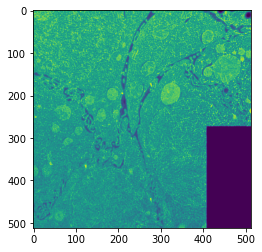

In [16]:
plt.imshow(image[0, ...])

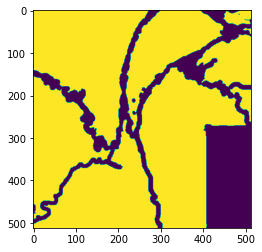

In [17]:
plt.imshow(mask[0, :, :])

Now let's load the dataset and visualize it with a simple function:

In [25]:
tile_size = (512, 512)

In [26]:
train_images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
train_labels_dir = data_dir / "corrected_labels" / "train"
train_data = EMDataset(train_images_dir, train_labels_dir, tile_size=tile_size)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

In [27]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0])                     # show the image
    axarr[1].imshow(mask[0])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    plt.show()

Image size is {torch.Size([512, 512])}


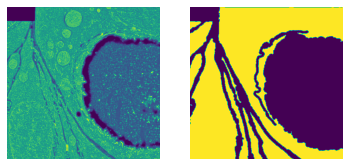

In [28]:
show_random_dataset_image(train_data)

And the same for the validation data:

In [29]:
test_images_dir = data_dir / "F107_bin2_619-639_frames" / "test"
test_labels_dir = data_dir / "corrected_labels" / "test"
test_data = EMDataset(test_images_dir, test_labels_dir, tile_size=tile_size)
val_loader = DataLoader(test_data, batch_size=1)

Image size is {torch.Size([512, 512])}


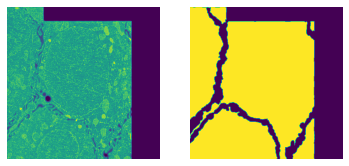

In [30]:
show_random_dataset_image(test_data)

## The model: U-net

Now we need to define the architecture of the model to use. This time we will use a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) that has proven to steadily outperform the other architectures in segmenting biological and medical images.

The image of the model precisely describes all the building blocks you need to use to create it. All of them can be found in the list of PyTorch layers (modules) [here](https://pytorch.org/docs/stable/nn.html#convolution-layers).

The U-net has an encoder-decoder structure:
In the encoder pass, the input image is successively downsampled via max-pooling. In the decoder pass it is upsampled again via transposed convolutions.
In adddition, it has skip connections, that bridge the output from an encoder to the corresponding decoder.

In [48]:
class UNet(nn.Module):
    """ UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """
    
    # _conv_block and _upsampler are just helper functions to
    # construct the model.
    # encapsulating them like so also makes it easy to re-use
    # the model implementation with different architecture elements
    
    # Convolutional block for single layer of the decoder / encoder
    # we apply to 2d convolutions with relu activation
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU())       


    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size=2, stride=2)
    
    def __init__(self, in_channels=1, out_channels=1, tile_size=(512, 512),
                 final_activation=None):
        super().__init__()
        
        # the depth (= number of encoder / decoder levels) is
        # hard-coded to 4
        self.depth = 4

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(final_activation, nn.Module), "Activation must be torch module"
        
        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList
        init_chan = 64
        
        # modules of the encoder path
        self.encoder = nn.ModuleList([self._conv_block(in_channels, init_chan),
                                      self._conv_block(init_chan, init_chan * 2 ** 1),
                                      self._conv_block(init_chan * 2 ** 1, init_chan * 2 ** 2),
                                      self._conv_block(init_chan * 2 ** 2, init_chan * 2 ** 3)])
        # the base convolution block
        self.base = self._conv_block(init_chan * 2 ** 3, init_chan * 2 ** 4)
        # modules of the decoder path
        self.decoder = nn.ModuleList([self._conv_block(init_chan * 2 ** 4, init_chan * 2 ** 3),
                                      self._conv_block(init_chan * 2 ** 3, init_chan * 2 ** 2),
                                      self._conv_block(init_chan * 2 ** 2, init_chan * 2 ** 1),
                                      self._conv_block(init_chan * 2 ** 1, init_chan)])
        
        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        # the upsampling layers
        image_size = tile_size[0]
        self.upsamplers = nn.ModuleList([self._upsampler(init_chan * 2 ** 4, init_chan * 2 ** 3),
                                         self._upsampler(init_chan * 2 ** 3, init_chan * 2 ** 2),
                                         self._upsampler(init_chan * 2 ** 2, init_chan * 2 ** 1),
                                         self._upsampler(init_chan * 2 ** 1, init_chan)])
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv2d(init_chan, out_channels, 1)
        self.activation = final_activation
    
    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)
        
        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            print(level)
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))
        
        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

## Loss and distance metrics

Next, we need to define the loss function - a metric that will tell us how close we are to the desired output. This metric should be differentiable, since it needs to be backpropagated. The are [multiple losses](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html) we could use for the segmentation task.

Take a moment to think which one is better to use for our exercise. If you are not sure, don't forget that you can always google! Before you start implementing the loss yourself, take a look at the [losses](https://pytorch.org/docs/stable/nn.html#loss-functions) already implemented in PyTorch. You can also look for implementations on GitHub.

__TASK__: implement your loss (or take one from pytorch):

We will use the [Dice Coefficeint](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the network predictions.
We can use it for validation if we interpret set $a$ as predictions and $b$ as labels. It is often used to evaluate segmentations with sparse foreground, because the denominator normalizes by the number of foreground pixels.
The Dice Coefficient is closely related to Jaccard Index / Intersection over Union.

In [32]:
# Copied from https://github.com/constantinpape/torch-em/blob/4b3205048a21308b30a832170aa2d41f400eff98/torch_em/loss/dice.py

def flatten_samples(input_):
    """
    Flattens a tensor or a variable such that the channel axis is first and the sample axis
    is second. The shapes are transformed as follows:
        (N, C, H, W) --> (C, N * H * W)
        (N, C, D, H, W) --> (C, N * D * H * W)
        (N, C) --> (C, N)
    The input must be atleast 2d.
    """
    # Get number of channels
    num_channels = input_.size(1)
    # Permute the channel axis to first
    permute_axes = list(range(input_.dim()))
    permute_axes[0], permute_axes[1] = permute_axes[1], permute_axes[0]
    # For input shape (say) NCHW, this should have the shape CNHW
    permuted = input_.permute(*permute_axes).contiguous()
    # Now flatten out all but the first axis and return
    flattened = permuted.view(num_channels, -1)
    return flattened


def dice_score(input_, target, invert=False, channelwise=True, eps=1e-7):
    if channelwise:
        # Flatten input and target to have the shape (C, N),
        # where N is the number of samples
        input_ = flatten_samples(input_)
        target = flatten_samples(target)
        # Compute numerator and denominator (by summing over samples and
        # leaving the channels intact)
        numerator = (input_ * target).sum(-1)
        denominator = (input_ * input_).sum(-1) + (target * target).sum(-1)
        channelwise_score = 2 * (numerator / denominator.clamp(min=eps))
        if invert:
            channelwise_score = 1. - channelwise_score
        # Sum over the channels to compute the total score
        score = channelwise_score.sum()
    else:
        numerator = (input_ * target).sum()
        denominator = (input_ * input_).sum() + (target * target).sum()
        score = 2. * (numerator / denominator.clamp(min=eps))
        if invert:
            score = 1. - score
    return score


class DiceLoss(nn.Module):
    def __init__(self, channelwise=True, eps=1e-7):
        super().__init__()
        self.channelwise = channelwise
        self.eps = eps

        # all torch_em classes should store init kwargs to easily recreate the init call
        self.init_kwargs = {"channelwise": channelwise, "eps": self.eps}

    def forward(self, input_, target):
        return dice_score(input_, target,
                          invert=True, channelwise=self.channelwise,
                          eps=self.eps)

## Training

Let's start with writing training and validation functions. __TASK__: fix in all the TODOs to make the function run. You can use the function from the classification exercises as a template.

In [44]:
# apply training for one epoch
def train(model, loader, optimizer, loss_function,
          epoch, log_interval=100, log_image_interval=20, tb_logger=None):

    # set the model to train mode
    model.train()
    
    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        
        # apply model, calculate loss and run backwards pass
        prediction = model(x)
        print(prediction.shape)
        loss = loss_function(prediction, y)
        loss.backward()
        optimizer.step()
        
        # log to console
        if batch_id % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_id * len(x),
                  len(loader.dataset),
                  100. * batch_id / len(loader), loss.item()))

       # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(tag='train_loss', scalar_value=loss.item(), global_step=step)
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                tb_logger.add_images(tag='input', img_tensor=x.to('cpu'), global_step=step)
                tb_logger.add_images(tag='target', img_tensor=y[:, 1:2, :, :].to('cpu'), global_step=step)
                tb_logger.add_images(tag='prediction', img_tensor=prediction[:, 1:2, :, :].to('cpu').detach(), global_step=step)

In [63]:
# run validation after training epoch
def validate(model, loader, loss_function, metric, step=None, tb_logger=None):
    # set model to eval mode
    model.eval()
    # running loss and metric values
    val_loss = 0
    val_metric = 0
    
    # disable gradients during validation
    with torch.no_grad():
        
        # iterate over validation loader and update loss and metric values
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            prediction = model(x)
            val_loss += loss_function(prediction, y)
            val_metric += metric(prediction, y)
    
    # normalize loss and metric
    val_loss /= len(loader)
    val_metric /= len(loader)
    
    if tb_logger is not None:
        assert step is not None, "Need to know the current step to log validation results"
        tb_logger.add_scalar(tag='val_loss', scalar_value=val_loss, global_step=step)
        tb_logger.add_scalar(tag='val_metric', scalar_value=val_metric, global_step=step)
        # we always log the last validation images
        tb_logger.add_images(tag='val_input', img_tensor=x.to('cpu'), global_step=step)
        # tb_logger.add_images(tag='val_target', img_tensor=y.to('cpu')[:, 1, :, :], global_step=step)
        print("Test y shape", y.shape)
        print("Test prediction shape", prediction.shape)
        tb_logger.add_images(tag='val_target', img_tensor=y[:, 1:2, :, :].to('cpu'), global_step=step)
        tb_logger.add_images(tag='val_prediction', img_tensor=prediction[:, 1:2, :, :].to('cpu'), global_step=step)
        
    print('\nValidate: Average loss: {:.4f}, Average Metric: {:.4f}\n'.format(val_loss, val_metric))


This time we will use GPU to train faster. Please make sure that your Notebook is running on GPU. 

In [53]:
for i in range(torch.cuda.device_count()):
    print(i, torch.cuda.get_device_name(i))
    print(i, torch.cuda.get_device_properties(i))

0 GeForce RTX 2080 Ti
0 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
1 GeForce RTX 2080 Ti
1 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
2 GeForce RTX 2080 Ti
2 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
3 GeForce RTX 2080 Ti
3 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
4 GeForce RTX 2080 Ti
4 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
5 GeForce RTX 2080 Ti
5 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
6 GeForce RTX 2080 Ti
6 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11019MB, multi_processor_count=68)
7 GeForce RTX 2080 T

In [36]:
# check if we have  a gpu
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device(4)
else:
    print("GPU is not available")
    device = torch.device("cpu")

GPU is available


In [37]:
device

device(type='cuda', index=4)

In [38]:
torch.cuda.current_device()

0

In [39]:
# start a tensorboard writer
logger = SummaryWriter('runs/Unet')
%tensorboard --logdir runs

Reusing TensorBoard on port 6008 (pid 144186), started 3 days, 23:35:22 ago. (Use '!kill 144186' to kill it.)

In [49]:
# build a default unet with sigmoid activation
# to normalize predictions to [0, 1]
net = UNet(1, 4, final_activation=nn.Sigmoid())
# move the model to GPU
net = net.to(device)

In [50]:
net

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (base): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [65]:
# use adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= "min", factor=0.5, patience=5)

# build the dice coefficient metric
metric = DiceLoss()
loss_function = DiceLoss() 

# train for 25 epochs
# during the training you can inspect the 
# predictions in the tensorboard
n_epochs = 500
for epoch in range(n_epochs):
    # train
    train(net, train_loader, optimizer, loss_function,
          epoch, log_interval=100, log_image_interval=20, tb_logger=logger)

    step = epoch * len(train_loader.dataset)
    # validate
    validate(net, val_loader, loss_function, metric, step=step, tb_logger=logger)

0
1
2
3
torch.Size([1, 4, 512, 512])
Train Epoch: 0 [0/9 (0%)]	Loss: 2.078770
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
Test y shape torch.Size([1, 4, 512, 512])
Test prediction shape torch.Size([1, 4, 512, 512])

Validate: Average loss: 2.6485, Average Metric: 2.6485

0
1
2
3
torch.Size([1, 4, 512, 512])
Train Epoch: 1 [0/9 (0%)]	Loss: 3.000000
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
torch.Size([1, 4, 512, 512])
0
1
2
3
Test y shape torch.Size([1, 4, 512, 512])
Test prediction shape torch.Size([1, 4, 512,

In [50]:
net

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (base): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
tb_logg

## Additional Exercises 

1. Implement and compare at least 2 of the following architecture variants of the U-Net:
    * use [Dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers) in the decoder path
    * use [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) to normalize layer inputs
    * use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm) to normalize convolutional group inputs
    * use [ELU-Activations](https://pytorch.org/docs/stable/nn.html#torch.nn.ELU) instead of ReLU-Activations

2. Use the Dice coefficient as loss function. Before we only used it for validation, but it is differentiable and can thus also be used as loss. Compare to the results from exercise 2. 
Hint: The optimizer we use finds minima of the loss, but the minimal value for the Dice coefficient corresponds to a bad segmentation. How do we need to change the Dice coefficient to use it as loss nonetheless?

3. Add one more layer to the U-net model (currently it has 4). Compare the results.

## Advanced Exercises

1. Visualize the graph (model) that we are using with TensorBoard
2. Write your own data transform (e.g., RandomRotate)